In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def convert_duration_to_seconds(duration):
    pattern = r'PT(\d+H)?(\d+M)?(\d+S)?'
    hours, minutes, seconds = re.match(pattern, duration).groups()
    
    total_seconds = 0
    if hours:
        total_seconds += int(hours[:-1]) * 3600
    if minutes:
        total_seconds += int(minutes[:-1]) * 60
    if seconds:
        total_seconds += int(seconds[:-1])
    
    return total_seconds

In [3]:
# Import datasets
train_df = pd.read_csv("../data/dataset/train/train.csv")
validate_df = pd.read_csv("../data/dataset/validation/validation.csv")
train_audio_df = pd.read_csv("../data/dataset/train/train_audio_clean.csv")
validate_audio_df = pd.read_csv("../data/dataset/validation/validation_audio_clean.csv")
train_audio2_df = pd.read_csv("../data/dataset/train/train_audio2.csv")
train_audio2_2_df = pd.read_csv("../data/dataset/train/train_audio2_2.csv")
validate_audio2_df = pd.read_csv("../data/dataset/validation/validation_audio2.csv")
validate_audio2_2_df = pd.read_csv("../data/dataset/validation/validation_audio2_2.csv")
train_visual_df = pd.read_csv("../data/dataset/train/train_visual.csv")
validate_visual_df = pd.read_csv("../data/dataset/validation/validation_visual.csv")

In [4]:
# Merging in audio and visual data
train_df = train_df.merge(train_visual_df, on='id')
train_df = train_df.merge(train_audio_df, on='id')
train_df = train_df.merge(train_audio2_2_df, on='id')
validate_df = validate_df.merge(validate_visual_df, on='id')
validate_df = validate_df.merge(validate_audio_df, on='id')
validate_df = validate_df.merge(validate_audio2_2_df, on='id')

In [58]:
# Set the input training data
# duration_train = train_df['duration'].apply(convert_duration_to_seconds).values.reshape(-1, 1)
X_train = train_df[['colorfulness', 'speech_rate', 'pitch_mean']]
# X_train['duration'] = duration_train

In [59]:
# Set the output training data
# y_train = train_df['likes_per_view']
y_train = train_df['views_per_week']

In [60]:
# Set the input predictive data
# duration_validation = validate_df['duration'].apply(convert_duration_to_seconds).values.reshape(-1, 1)
X_validate = validate_df[['colorfulness', 'speech_rate', 'pitch_mean']]
# X_validate['duration'] = duration_validation

In [61]:
# Scale the features using standardization
scaler = StandardScaler()
X_train.reset_index()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_validate)

# Confirm scaling worked correctly
# print("Training input data mean after scale = " + str(np.mean(X_train_scaled)))
# print("Training input data variance after scale = " + str(np.var(X_train_scaled)))
# print("Testing input data mean after scale = " + str(np.mean(X_train_scaled)))
# print("Testind input data variance after scale = " + str(np.var(X_train_scaled)))

In [62]:
# Fill Nans if necessary
X_train_scaled[np.isnan(X_train_scaled)] = 0

In [63]:
# Fit and predict the linear regression model
reg = LinearRegression().fit(X_train_scaled, y_train)
predictions = reg.predict(X_test_scaled)
print(predictions)

[382.92494406 348.00032293 203.31917769 248.3626761  269.06921851
 285.24052128 218.61565425 300.83657171 267.64261681 309.62170928
 252.66265637 396.53804419 288.23805942 288.24381111 283.97747542
  17.37146587 281.18706125 202.82649976 388.37524191 489.81864887
 348.48385787 199.77432487 244.19981788 245.41185707 273.99444326
 222.64178326 375.34015671 240.48011118 245.95955488 424.88440077
 242.74984402 429.39579638 230.7563254  244.03211674 202.87526933
 264.7657284  176.68102828 136.42258765 159.75560269 225.53091978
 174.29749177 401.40146626 289.05739548]


In [48]:
# Output lpv predictions to csv file
# MAKE SURE ITS THE RIGHT FILE!!!
linreg_df = pd.DataFrame(columns=['id', 'likes_per_view_predicted', 'likes_per_view_actual'])
linreg_df['id'] = validate_df['id']
linreg_df['likes_per_view_predicted'] = predictions
linreg_df['likes_per_view_actual'] = validate_df['likes_per_view']
linreg_df.to_csv("../data/dataset/models/linreg/6_n_2.csv", header=True, index=False)

In [64]:
# Output vpw predictions to csv file
# MAKE SURE ITS THE RIGHT FILE!!!!
linreg_df['views_per_week_predicted'] = predictions
linreg_df['views_per_week_actual'] = validate_df['views_per_week']
linreg_df.to_csv("../data/dataset/models/linreg/6_n_2.csv", header=True, index=False)

In [65]:
# Find feature importance through coefficients
importance = reg.coef_

# Find intercept
intercept = reg.intercept_
print("intercept: " + str(intercept))

# Summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

intercept: 268.7116168405716
Feature: 0, Score: -34.75104
Feature: 1, Score: 83.53417
Feature: 2, Score: -57.69002


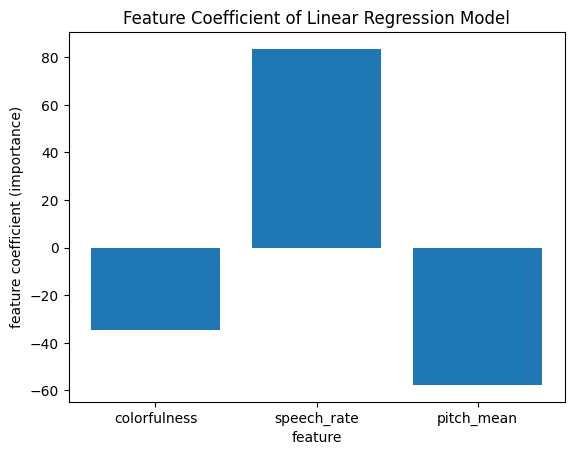

In [66]:
# plot feature importance
plt.bar(['colorfulness' ,'speech_rate', 'pitch_mean'], importance)
plt.xlabel('feature')
plt.ylabel('feature coefficient (importance)')
plt.title('Feature Coefficient of Linear Regression Model')
plt.show()

In [67]:
# Calculate errors
# Likes
actual_outputs = linreg_df['likes_per_view_actual']*100
predicted_outputs = linreg_df['likes_per_view_predicted']*100

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_outputs, predicted_outputs)
print("Mean Absolute Error for LPV:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_outputs, predicted_outputs, squared=False)
print("Root Mean Squared Error for LPV:", rmse)

# Views
actual_outputs = linreg_df['views_per_week_actual']
predicted_outputs = linreg_df['views_per_week_predicted']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_outputs, predicted_outputs)
print("Mean Absolute Error for VPW:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_outputs, predicted_outputs, squared=False)
print("Root Mean Squared Error for VPW:", rmse)

Mean Absolute Error for LPV: 0.5546323334690979
Root Mean Squared Error for LPV: 0.6639143595672323
Mean Absolute Error for VPW: 193.2623311837815
Root Mean Squared Error for VPW: 344.80158438812157
